In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
plt.style.use('dark_background')

### Exercise H8.1: K-means Clustering – batch version

In [2]:
X = np.loadtxt('cluster.dat').T
Ms = np.arange(2, 9, 1)

In [3]:
mean = np.mean(X, axis = 0)
t_max = 5

In [4]:
def plt_prototypes(X, W, M, voronoi=False):
    fig, axs = plt.subplots(2, 3, figsize = (13, 6), constrained_layout = True)
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        if not i == 0:
            plt.title(f'Data points and prototypes at iteration t = {i-1}')
            plt.scatter(X[:,0], X[:,1])
            plt.scatter(W[i,:][:,0], W[i,:][:,1], c = 'red')
        elif i == 0 and not voronoi:
            plt.title('Scatter plot of the data set')
            plt.scatter(X[:,0], X[:,1])
        elif i == 0 and voronoi:
            plt.title('Voronoi-Tessalation plot')
            plt.scatter(W[-1,:][:,0], W[-1,:][:,1], c = 'red')
            vor = Voronoi(W[-1])
            voronoi_plot_2d(vor, ax = axs[0,0], show_vertices=False, line_colors='orange',
                line_width=2, line_alpha=0.6, point_size=2)
            
    plt.suptitle(f'Visualization of data points and prototypes for M = {M}', fontsize = 14)
    plt.xlabel(r'$x_0$')
    plt.ylabel(r'$x_1$', rotation = 'horizontal')
    plt.show()

def plt_error(t_max, M, E):
    fig = plt.subplots(figsize = (13, 3), constrained_layout = True)
    plt.plot(np.arange(0, t_max, 1), E)
    plt.title(fr'Error function $E$ over iteration $t$ for M = {M}')
    plt.xlabel(r'iteration $t$')
    plt.ylabel('error')
    plt.show()

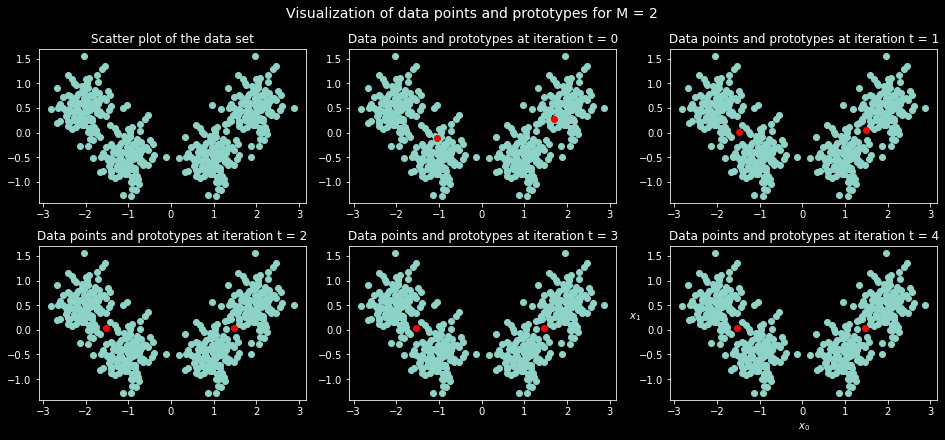

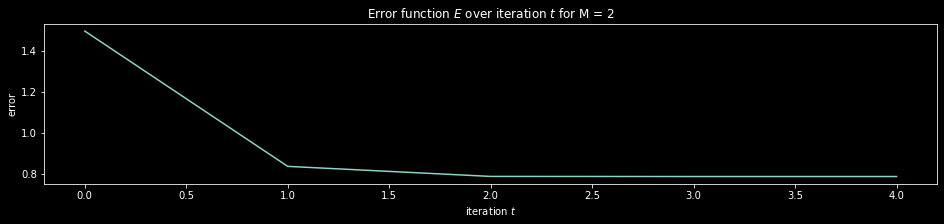

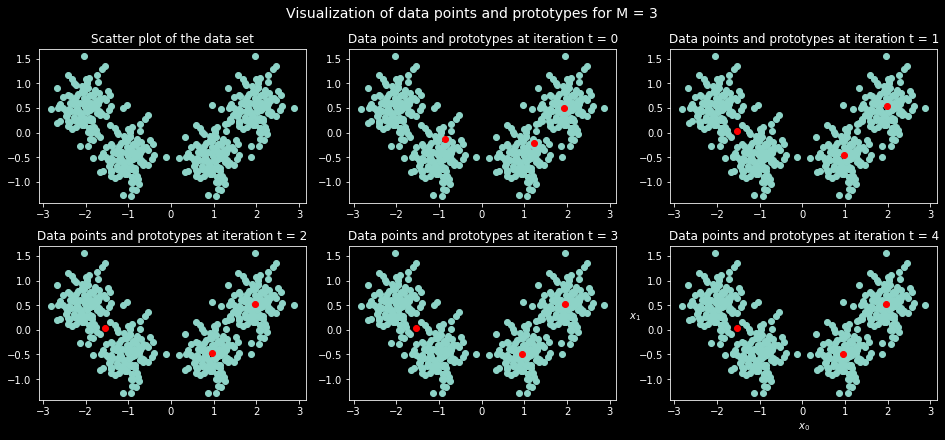

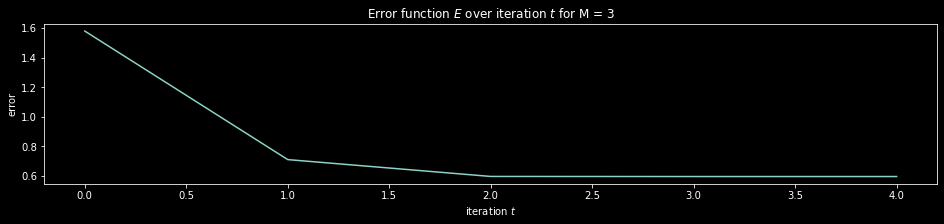

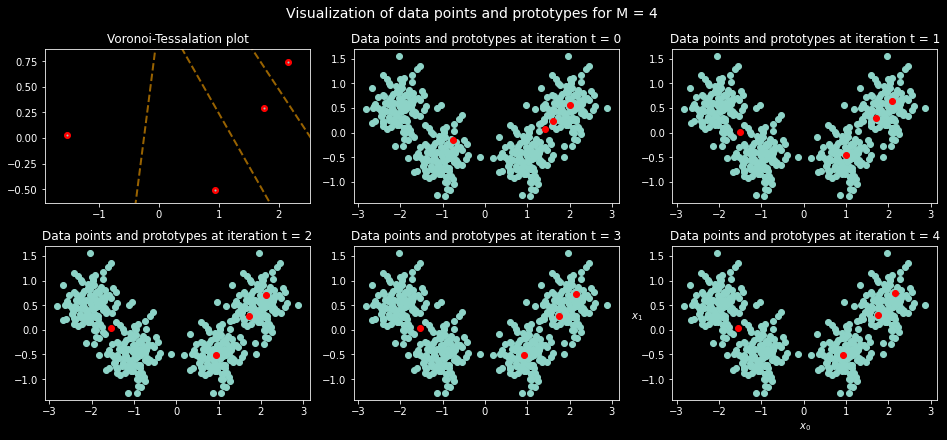

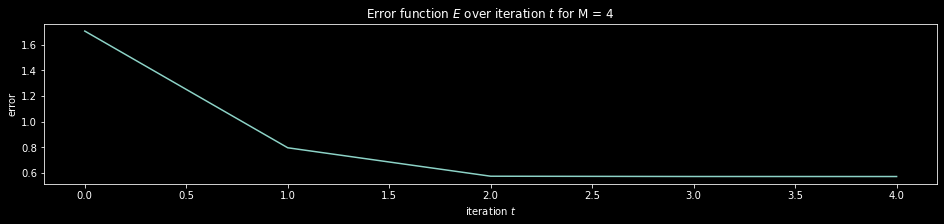

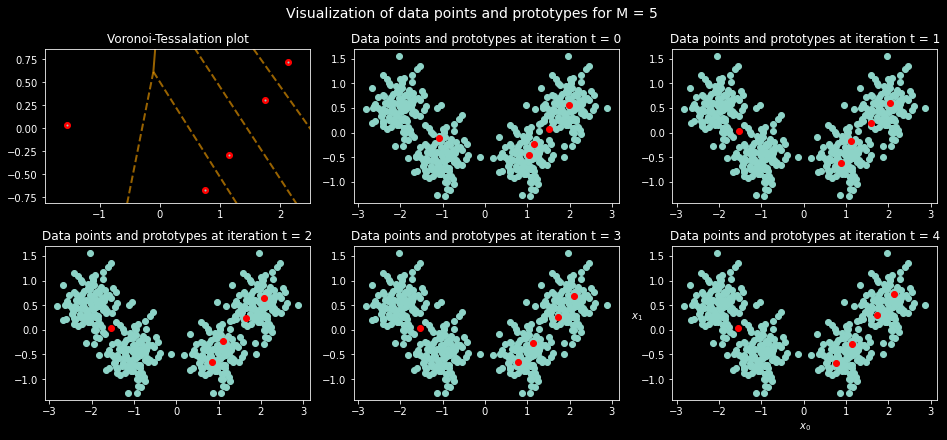

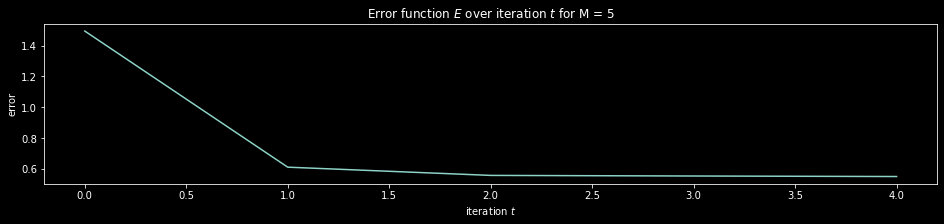

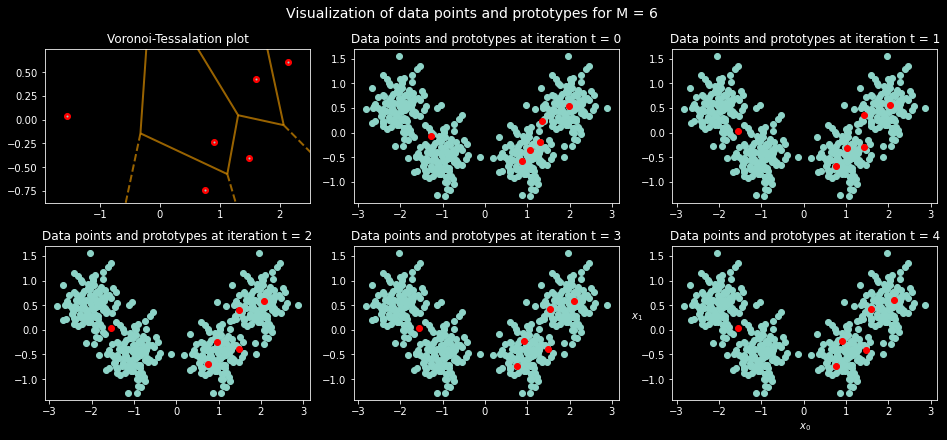

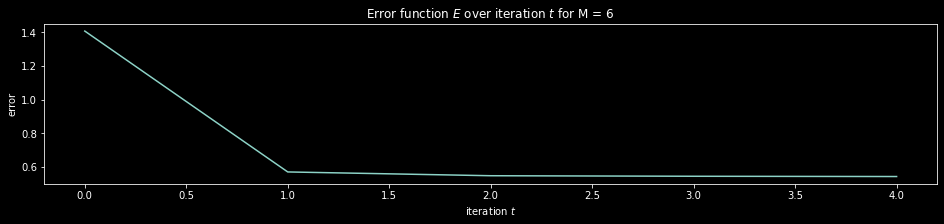

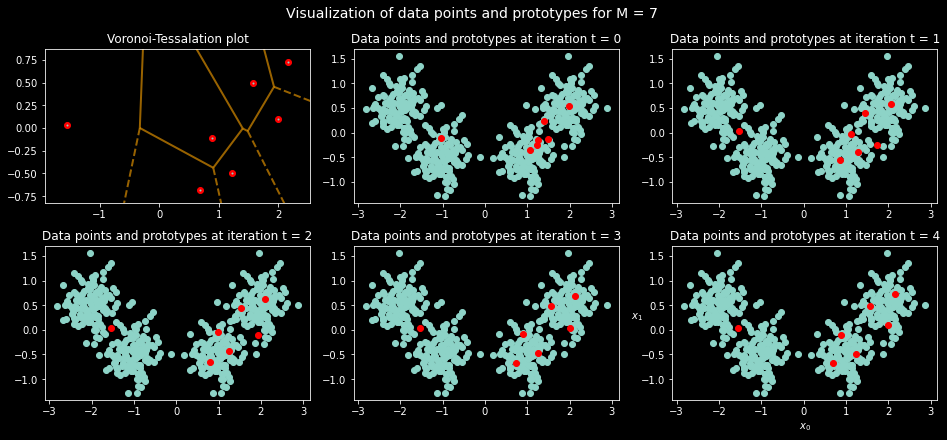

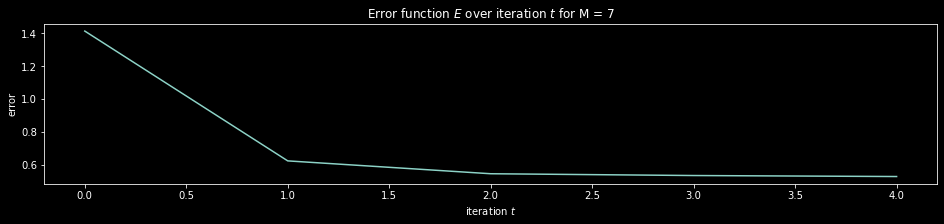

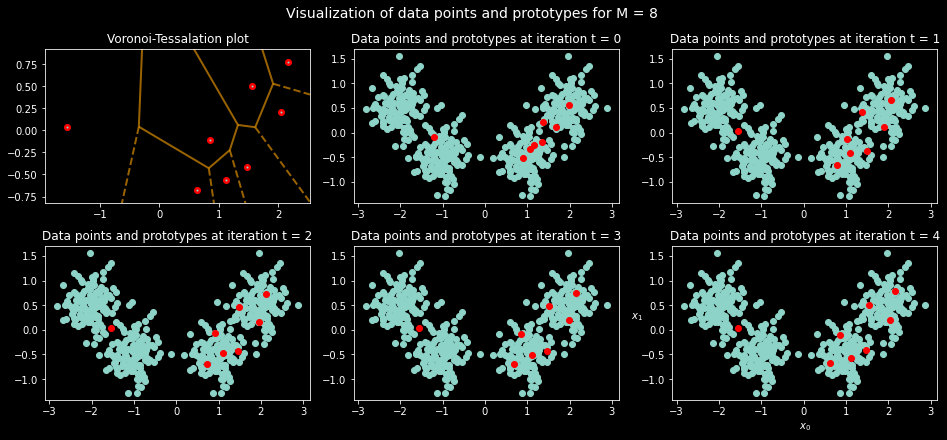

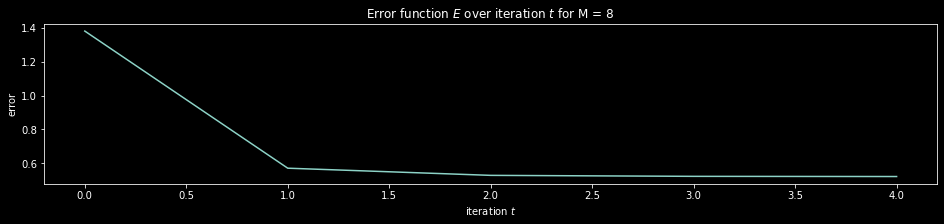

In [5]:
for M in Ms:
    # A: Initialization.
    np.random.seed(0+M)
    w = np.array([mean + np.random.rand() for i in range(M)])
    
    W = np.zeros((t_max+1, M, 2))  # store prototypes over iterations
    E = np.zeros(t_max)
    W[0] = w
    
    # B: Optimization.
    for t in range(t_max):
        distances = np.array([[np.linalg.norm(X[i]-w[m]) for m in range(M)] for i in range(len(X))])
        m_q = np.array([[1 if distances[i,q] == np.min(distances[i]) else 0 for q in range(M)] for i in range(len(X))])
        w = np.array([(m_q.T @ X)[q] / (np.sum([m_q[:,j] for j in range(M)], axis = 1))[q] for q in range(M)])
        W[t+1] = w
        E[t] = 1 / len(X) * np.sum([m_q[i].reshape(1, M) @ distances[i].reshape(M, 1) for i in range(len(X))])
    
    # C: Visualization.
    if M > 3:
        plt_prototypes(X, W, M, voronoi = True)
    else:
        plt_prototypes(X, W, M)
    plt_error(t_max, M, E)

### Exercise H8.2: Online K-means Clustering

__A: Initialization:__

In [6]:
M = 4
np.random.seed(10)
w = np.array([mean + np.random.rand(2) for i in range(M)])
epsilon = 0.1
t_max = len(X)
tau = 0.2
W = np.zeros((t_max+1, M, 2))  # store prototypes over iterations
W[0] = w

__B: Optimization:__

In [7]:
m_q = np.zeros((t_max, M))
for t, x in enumerate(X):
    distance = np.array([np.linalg.norm(x - w[m]) for m in range(M)])
    q = np.argmin(distance)
    m_q[t, q] = 1
    if t >= int(t_max/4):
        epsilon = tau * epsilon
    w = W[t]
    w[q] += epsilon * (x - w[q])
    W[t+1] = w

__C: Visualization:__

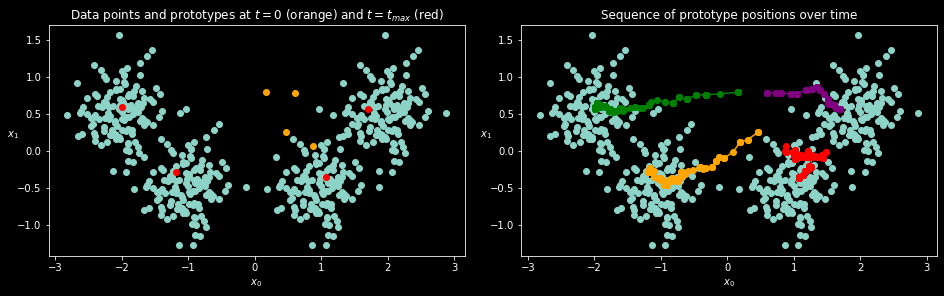

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (13, 4), constrained_layout = True)

axs[0].set_title(r'Data points and prototypes at $t = 0$ (orange) and $t = t_{max}$ (red)')
axs[0].scatter(X[:,0], X[:,1])
axs[0].scatter(W[0][:,0], W[0][:,1], c = 'orange')
axs[0].scatter(W[-1][:,0], W[-1][:,1], c = 'red')

axs[1].set_title(r'Sequence of prototype positions over time')
axs[1].scatter(X[:,0], X[:,1])
colors = ['red', 'purple', 'orange', 'green']
for i in range(M):
    axs[1].scatter(W[:,i][:,0], W[:,i][:,1], c = colors[i])
    axs[1].plot(W[:,i][:,0], W[:,i][:,1], c = colors[i])

for j in range(2):
    axs[j].set_xlabel(r'$x_0$')
    axs[j].set_ylabel(r'$x_1$', rotation = 'horizontal')
plt.show()

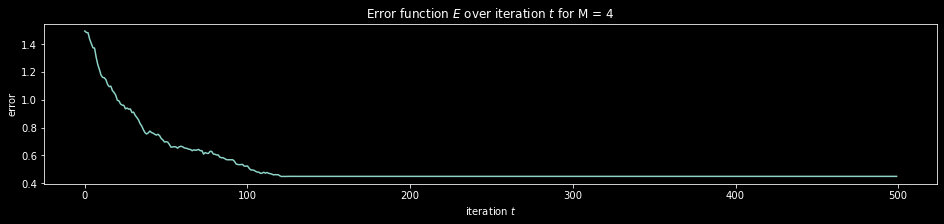

In [9]:
E = np.zeros(t_max)
# Calculate the error after each iteration with the respective prototypes.
for t in range(t_max):  
    E[t] = 1/ len(X) * np.sum([m_q[i].reshape(1, M) @ np.array([np.linalg.norm(X[i] - W[t,j]) for j in range(M)]) 
                            for i in range(len(X))])
plt_error(t_max, M, E)

__Observation:__ 

We can see that the prototypes are now more clearly assigned to the four clusters (visual inspection). From this we can infer that the online K-means clustering is in fact able to escape local minima. 

This can be explained by looking at the error function. We see that the error functoin $E$ decreases over time but not as straight as before. We can observe some kind of noisiness in the function for $t < \frac{t_{max}}{4}$. This is caused by the "annealing" schedule we chose. For the first $\frac{t_{max}}{4} - 1 = 124$ iterations, we used the $\epsilon$ defined in the beginning, i.e. we were in an __exploration__ mode. This enabled the algorithm to end up with a $\Delta \mathbf{w_q}$ that actually did change the prototypes after each time step a little bit which explains the fluctuations caused by these updates. This allowed the algorithm to excape local minima. After $t \geq \frac{t_{max}}{4}$, we transitioned into an __exploitation__ mode, essentially decreasing the amount of change on the prototypes over time leading to a strong decrease of the error curve.

Whether we end up with an "optimal" solution still highly depends on the choice of the initialization of the prototypes and of the choice of the $\epsilon$, so how conservative we are. In this setup for example, choosing a random seed of 0 caused us to get stuck in local minima again.

### Exercise H8.3: Soft K-means Clustering

__(a) Set $M = 12$ initial prototypes $\mathbf{w}_q$ randomly around the data set mean and choose a convergence tolerance $\theta$.__

In [10]:
M = 12
np.random.seed(10)
w = np.array([mean + np.random.rand(2) for i in range(M)])
theta = 0.2

__(b) For fixed $\beta$ (no annealing), let the optimization procedure run until convergence, that is $\parallel \mathbf{w}_{new} − \mathbf{w}_{old}\parallel_2 \, < \theta \, \forall q$. Repeat this for different $\beta$ $\in [0.2, 20]$ e.g. in steps of $\Delta \beta = 0.2$. Use the same initial prototypes for all runs.__

In [11]:
def soft_kmeans(X, M, w, beta, theta, tau=0, annealing = False):
    distance_w = 100
    count = 0
    W_store = w  # matrix to store prototypes over an unknown (!) number of iterations
    while distance_w >= theta:
        P_assignment = np.zeros((len(X), M))
        for i in range(len(X)):
            P_assignment[i] = [np.exp(-beta / 2 * np.linalg.norm(X[i] - w[q])) / np.sum([np.exp(-beta / 2 * np.linalg.norm(X[i] 
                                                                        - w[r])) for r in range(M)]) for q in range(M)]
        w_new = np.array([(P_assignment.T @ X)[q] / (np.sum([P_assignment[:,j] for j in range(M)], axis = 1))[q] for q in range(M)])
        
        distance_w = np.linalg.norm(w_new - w)
        W_store = np.append(W_store, w, axis = 0)  # add the new prototypes to the storing matrix
        w = w_new
        if annealing:
            beta = tau + beta
        count += 1
    
    W_store = np.array(np.split(W_store, count+1))
    return w, W_store

In [12]:
step_beta = 0.2
betas = np.arange(0.2, 20+step_beta, step_beta)
W = np.zeros((len(betas), w.shape[0], w.shape[1]))
for idx, beta in enumerate(betas):
    W[idx],_  = soft_kmeans(X, M, w, beta, theta)

__(c) Visualize the data set, initial and final prototypes for each (fixed) $\beta$ in one scatter plot.__

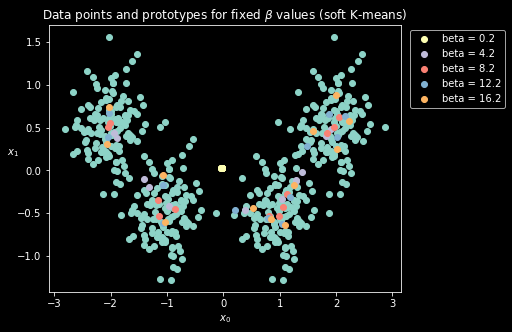

In [13]:
fig = plt.subplots(figsize = (7, 4.5), constrained_layout = True)
plt.scatter(X[:,0], X[:,1])
for idx, beta in enumerate(betas):
    if idx in np.arange(0, len(betas), 20):
        # Plot only a selection of prototypes instead of all 100.
        plt.scatter(W[idx][:,0], W[idx][:,1], label = f'beta = {beta}')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$', rotation = 'horizontal')
plt.title(r'Data points and prototypes for fixed $\beta$ values (soft K-means)')
plt.legend(bbox_to_anchor = (1.01, 1))
plt.show()

__(d) In additional simulations, run the optimization using an annealing schedule: increase $\beta$ after
each iteration. E.g. $\beta_0 = 0.2$, $\tau = 1.1$, $\beta_{t+1} = \tau \beta_t$.__

In [14]:
W_annealing, W_store = soft_kmeans(X, M, w, 16.2, theta, tau=1.1, annealing=True)

__(e) Show the data set, initial and final prototypes of the “annealed" clustering solutions in a scatter plot. Additionally, show the position of each prototype ($x_2$ coordinate only) as a function of $t –$ all in one figure (i.e., $M = 12$ lines).__

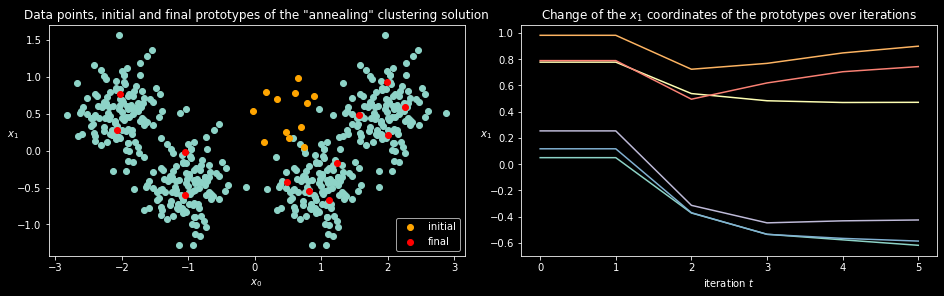

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (13, 4), constrained_layout = True)
axs[0].scatter(X[:,0], X[:,1])
axs[0].scatter(W_store[0][:,0], W_store[0][:,1], c = 'orange', label = 'initial')
axs[0].scatter(W_annealing[:,0], W_annealing[:,1], c = 'red', label = 'final')
axs[0].set_xlabel(r'$x_0$')
axs[0].set_ylabel(r'$x_1$', rotation = 'horizontal')
axs[0].set_title('Data points, initial and final prototypes of the "annealing" clustering solution')
axs[0].legend(loc = 'lower right')

iterations = np.arange(0, len(W_store), 1)
for i in range(len(W_store)):
    axs[1].plot(iterations, W_store[:,i,1])
axs[1].set_title(r'Change of the $x_1$ coordinates of the prototypes over iterations')
axs[1].set_xlabel(f'iteration $t$')
axs[1].set_ylabel(r'$x_1$', rotation = 'horizontal')

plt.show()

__Observation:__ We see that the data points are now much softer assigned now, in the sense that each cluster seems to be assigned to multiple prototypes now. The two left clusters are each assigned to 2 prototypes, whereas the two clusters on the right seem to be assigned to 4 prototypes each now.